<a href="https://colab.research.google.com/github/mateuspalacio/grupo_four_jupyter/blob/main/AV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from math import sqrt
from datetime import date, timedelta
%tensorflow_version 2.x
import tensorflow as tf
from sklearn.exceptions import ConvergenceWarning
from tensorflow.keras.layers import LeakyReLU, Dense

from google.colab import drive
drive.mount('/content/drive/')

from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

transformar_features = True

import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import multiprocessing as mp

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
tf.test.gpu_device_name()

''

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
path = os.path.join('VendasTesouroDireto_1.json')
values = pd.read_json(path)
df_data = pd.DataFrame(values)
df_data['Tipo_Titulo'] = df_data['Tipo_Titulo'].astype('str') 
df_data['PU'] = df_data['PU'].str.replace(',', '.')
df_data['Quantidade'] = df_data['Quantidade'].str.replace(',', '.')
df_data['Valor'] = df_data['Valor'].str.replace(',', '.')
df_data['PU'] = pd.to_numeric(df_data['PU'],errors='coerce')
df_data['Quantidade'] = pd.to_numeric(df_data['Quantidade'], errors='coerce')
df_data['Valor'] = pd.to_numeric(df_data['Valor'], errors='coerce')

df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'],errors='coerce',dayfirst=True)
 
df_data['Data_Venda'] = pd.to_datetime(df_data['Data_Venda'],errors='coerce', dayfirst=True)

df_data

,Tipo_Titulo,Vencimento_do_Titulo,Data_Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,2012-08-15,2008-12-05,1655.206735,38.6,63890.97
1,Tesouro IPCA+ com Juros Semestrais,2017-05-15,2008-12-05,1480.154343,571.0,845168.12
2,Tesouro Prefixado com Juros Semestrais,2014-01-01,2008-12-05,870.303177,283.2,246469.85
3,Tesouro Prefixado com Juros Semestrais,2012-01-01,2008-12-05,936.285273,29.2,27339.52
4,Tesouro Prefixado com Juros Semestrais,2017-01-01,2008-12-05,808.587250,491.8,397663.20
...,...,...,...,...,...,...
66164,Tesouro Prefixado com Juros Semestrais,2010-01-01,2008-08-27,960.339019,110.2,105829.35
66165,Tesouro IPCA+ com Juros Semestrais,2010-08-15,2008-08-27,1672.613421,271.2,453612.75
66166,Tesouro IPCA+ com Juros Semestrais,2011-05-15,2008-08-27,1677.517573,88.2,147957.04
66167,Tesouro Prefixado com Juros Semestrais,2010-07-01,2008-08-27,946.566666,0.6,567.93


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66169 entries, 0 to 66168
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Tipo_Titulo           66169 non-null  object        
 1   Vencimento_do_Titulo  66169 non-null  datetime64[ns]
 2   Data_Venda            66169 non-null  datetime64[ns]
 3   PU                    66169 non-null  float64       
 4   Quantidade            66169 non-null  float64       
 5   Valor                 66169 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 3.0+ MB


In [7]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Quantidade'])
aux.set_index('Data_Venda')
data_Value_Per_Day_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('d'))['Valor'].sum())
data_Value_Per_Day=pd.DataFrame(aux.groupby(aux['Data_Venda'].dt.to_period('d'))['Valor'].sum())
data_Value_Per_Day_Selic

,Valor
Data_Venda,
2002-01-07,15248.32
2002-01-08,42581.98
2002-01-09,7840.74
2002-01-10,252.18
2002-01-11,6315.69
...,...
2021-08-05,51618710.69
2021-08-06,64518858.59
2021-08-09,65513084.83


In [8]:
data_Value_Per_Day

,Valor
Data_Venda,
2002-01-04,5.677036e+04
2002-01-07,2.340568e+05
2002-01-08,2.266638e+05
2002-01-09,7.038599e+04
2002-01-10,8.449650e+04
...,...
2021-08-05,1.107823e+08
2021-08-06,1.679098e+08
2021-08-09,1.803391e+08


In [9]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Valor'])
aux.set_index('Data_Venda')
data_Amount_Per_Day_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('d'))['Quantidade'].sum())
data_Amount_Per_Day_Selic

,Quantidade
Data_Venda,
2002-01-07,12.20
2002-01-08,33.80
2002-01-09,6.20
2002-01-10,0.20
2002-01-11,5.00
...,...
2021-08-05,4765.41
2021-08-06,5953.69
2021-08-09,6044.49


In [10]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Valor'])
aux.set_index('Data_Venda')
data_Amount_Per_Day=pd.DataFrame(aux.groupby(aux['Data_Venda'].dt.to_period('d'))['Quantidade'].sum())
data_Amount_Per_Day

,Quantidade
Data_Venda,
2002-01-04,37.60
2002-01-07,263.60
2002-01-08,249.20
2002-01-09,80.40
2002-01-10,95.30
...,...
2021-08-05,40896.06
2021-08-06,65070.61
2021-08-09,76157.59


In [11]:
data_day = data_Amount_Per_Day_Selic.merge(data_Value_Per_Day_Selic,on='Data_Venda')
data_day['Data_Venda'] = data_day.index
data_day

,Quantidade,Valor,Data_Venda
Data_Venda,,,
2002-01-07,12.20,15248.32,2002-01-07
2002-01-08,33.80,42581.98,2002-01-08
2002-01-09,6.20,7840.74,2002-01-09
2002-01-10,0.20,252.18,2002-01-10
2002-01-11,5.00,6315.69,2002-01-11
...,...,...,...
2021-08-05,4765.41,51618710.69,2021-08-05
2021-08-06,5953.69,64518858.59,2021-08-06
2021-08-09,6044.49,65513084.83,2021-08-09


In [12]:
data_day_all = data_Amount_Per_Day.merge(data_Value_Per_Day,on='Data_Venda')
data_day_all['Data_Venda'] = data_day_all.index
data_day_all

,Quantidade,Valor,Data_Venda
Data_Venda,,,
2002-01-04,37.60,5.677036e+04,2002-01-04
2002-01-07,263.60,2.340568e+05,2002-01-07
2002-01-08,249.20,2.266638e+05,2002-01-08
2002-01-09,80.40,7.038599e+04,2002-01-09
2002-01-10,95.30,8.449650e+04,2002-01-10
...,...,...,...
2021-08-05,40896.06,1.107823e+08,2021-08-05
2021-08-06,65070.61,1.679098e+08,2021-08-06
2021-08-09,76157.59,1.803391e+08,2021-08-09


In [13]:
pu = df_data['Quantidade']
# será se deve ser essas colunas mesmo?
df_features = df_data.drop(columns=['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'Quantidade'])

df_features

,PU,Valor
0,1655.206735,63890.97
1,1480.154343,845168.12
2,870.303177,246469.85
3,936.285273,27339.52
4,808.587250,397663.20
...,...,...
66164,960.339019,105829.35
66165,1672.613421,453612.75
66166,1677.517573,147957.04
66167,946.566666,567.93


In [14]:
data_day['d_semana'] = data_day['Data_Venda'].dt.dayofweek
data_day['d_mes'] = data_day['Data_Venda'].dt.strftime("%d")
data_day['d_ano'] = data_day['Data_Venda'].dt.strftime("%j")

data_day['d_semana'] = data_day['d_semana'].astype(int)
data_day['d_mes'] = data_day['d_mes'].astype(int)
data_day['d_ano'] = data_day['d_ano'].astype(int)

data_day

,Quantidade,Valor,Data_Venda,d_semana,d_mes,d_ano
Data_Venda,,,,,,
2002-01-07,12.20,15248.32,2002-01-07,0,7,7
2002-01-08,33.80,42581.98,2002-01-08,1,8,8
2002-01-09,6.20,7840.74,2002-01-09,2,9,9
2002-01-10,0.20,252.18,2002-01-10,3,10,10
2002-01-11,5.00,6315.69,2002-01-11,4,11,11
...,...,...,...,...,...,...
2021-08-05,4765.41,51618710.69,2021-08-05,3,5,217
2021-08-06,5953.69,64518858.59,2021-08-06,4,6,218
2021-08-09,6044.49,65513084.83,2021-08-09,0,9,221


In [15]:
data_day_all['d_semana'] = data_day_all['Data_Venda'].dt.dayofweek
data_day_all['d_mes'] = data_day_all['Data_Venda'].dt.strftime("%d")
data_day_all['d_ano'] = data_day_all['Data_Venda'].dt.strftime("%j")

data_day_all['d_semana'] = data_day_all['d_semana'].astype(int)
data_day_all['d_mes'] = data_day_all['d_mes'].astype(int)
data_day_all['d_ano'] = data_day_all['d_ano'].astype(int)

data_day_all

,Quantidade,Valor,Data_Venda,d_semana,d_mes,d_ano
Data_Venda,,,,,,
2002-01-04,37.60,5.677036e+04,2002-01-04,4,4,4
2002-01-07,263.60,2.340568e+05,2002-01-07,0,7,7
2002-01-08,249.20,2.266638e+05,2002-01-08,1,8,8
2002-01-09,80.40,7.038599e+04,2002-01-09,2,9,9
2002-01-10,95.30,8.449650e+04,2002-01-10,3,10,10
...,...,...,...,...,...,...
2021-08-05,40896.06,1.107823e+08,2021-08-05,3,5,217
2021-08-06,65070.61,1.679098e+08,2021-08-06,4,6,218
2021-08-09,76157.59,1.803391e+08,2021-08-09,0,9,221


In [16]:


# data_day = data_day[data_day['Data_Venda'] >= '2017-08-01']
# data_day = data_day[data_day['Data_Venda'] <= '2020-08-30']
data_day = data_day[data_day['Data_Venda'] >= '2015-01-01']

data_day

,Quantidade,Valor,Data_Venda,d_semana,d_mes,d_ano
Data_Venda,,,,,,
2015-01-05,942.07,6155917.13,2015-01-05,0,5,5
2015-01-06,4093.30,26782657.93,2015-01-06,1,6,6
2015-01-07,3806.25,24915331.31,2015-01-07,2,7,7
2015-01-08,1464.76,9592359.52,2015-01-08,3,8,8
2015-01-09,1354.27,8872660.72,2015-01-09,4,9,9
...,...,...,...,...,...,...
2021-08-05,4765.41,51618710.69,2021-08-05,3,5,217
2021-08-06,5953.69,64518858.59,2021-08-06,4,6,218
2021-08-09,6044.49,65513084.83,2021-08-09,0,9,221


In [17]:

# data_day = data_day[data_day['Data_Venda'] >= '2017-08-01']
# data_day = data_day[data_day['Data_Venda'] <= '2020-08-30']
data_day_all = data_day_all[data_day_all['Data_Venda'] >= '2015-01-01']

data_day_all

,Quantidade,Valor,Data_Venda,d_semana,d_mes,d_ano
Data_Venda,,,,,,
2015-01-05,18543.27,2.408160e+07,2015-01-05,0,5,5
2015-01-06,98323.22,1.198855e+08,2015-01-06,1,6,6
2015-01-07,65926.58,8.766012e+07,2015-01-07,2,7,7
2015-01-08,28918.79,3.785516e+07,2015-01-08,3,8,8
2015-01-09,25624.36,3.345108e+07,2015-01-09,4,9,9
...,...,...,...,...,...,...
2021-08-05,40896.06,1.107823e+08,2021-08-05,3,5,217
2021-08-06,65070.61,1.679098e+08,2021-08-06,4,6,218
2021-08-09,76157.59,1.803391e+08,2021-08-09,0,9,221


In [18]:
feature_names = ['Quantidade', 'Valor','d_semana','d_mes','d_ano']
data_day_features=data_day.drop(columns=['Data_Venda'])
#data_day = data_day.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
data_day_features

,Quantidade,Valor,d_semana,d_mes,d_ano
Data_Venda,,,,,
2015-01-05,942.07,6155917.13,0,5,5
2015-01-06,4093.30,26782657.93,1,6,6
2015-01-07,3806.25,24915331.31,2,7,7
2015-01-08,1464.76,9592359.52,3,8,8
2015-01-09,1354.27,8872660.72,4,9,9
...,...,...,...,...,...
2021-08-05,4765.41,51618710.69,3,5,217
2021-08-06,5953.69,64518858.59,4,6,218
2021-08-09,6044.49,65513084.83,0,9,221


In [19]:
data_day_features_all=data_day_all.drop(columns=['Data_Venda'])
#data_day = data_day.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
data_day_features_all

,Quantidade,Valor,d_semana,d_mes,d_ano
Data_Venda,,,,,
2015-01-05,18543.27,2.408160e+07,0,5,5
2015-01-06,98323.22,1.198855e+08,1,6,6
2015-01-07,65926.58,8.766012e+07,2,7,7
2015-01-08,28918.79,3.785516e+07,3,8,8
2015-01-09,25624.36,3.345108e+07,4,9,9
...,...,...,...,...,...
2021-08-05,40896.06,1.107823e+08,3,5,217
2021-08-06,65070.61,1.679098e+08,4,6,218
2021-08-09,76157.59,1.803391e+08,0,9,221


In [20]:
# aplicando escala pros valores ficarem entre 0 e 1
if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))

    data_day_features[feature_names] = scaler.fit_transform(data_day_features[feature_names])

    data_day_features

In [21]:
# aplicando escala pros valores ficarem entre 0 e 1
if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))

    data_day_features_all[feature_names] = scaler.fit_transform(data_day_features_all[feature_names])

    data_day_features_all

In [22]:
data_day_features

,Quantidade,Valor,d_semana,d_mes,d_ano
Data_Venda,,,,,
2015-01-05,0.018456,0.008492,0.00,0.133333,0.008264
2015-01-06,0.109310,0.067409,0.25,0.166667,0.011019
2015-01-07,0.101034,0.062076,0.50,0.200000,0.013774
2015-01-08,0.033526,0.018308,0.75,0.233333,0.016529
2015-01-09,0.030340,0.016252,1.00,0.266667,0.019284
...,...,...,...,...,...
2021-08-05,0.128688,0.138350,0.75,0.133333,0.592287
2021-08-06,0.162948,0.175198,1.00,0.166667,0.595041
2021-08-09,0.165566,0.178038,0.00,0.266667,0.603306


In [23]:
    data_day_features_all

,Quantidade,Valor,d_semana,d_mes,d_ano
Data_Venda,,,,,
2015-01-05,0.028283,0.008424,0.00,0.133333,0.008264
2015-01-06,0.164561,0.076073,0.25,0.166667,0.011019
2015-01-07,0.109222,0.053318,0.50,0.200000,0.013774
2015-01-08,0.046006,0.018149,0.75,0.233333,0.016529
2015-01-09,0.040379,0.015040,1.00,0.266667,0.019284
...,...,...,...,...,...
2021-08-05,0.066466,0.069645,0.75,0.133333,0.592287
2021-08-06,0.107760,0.109984,1.00,0.166667,0.595041
2021-08-09,0.126698,0.118760,0.00,0.266667,0.603306


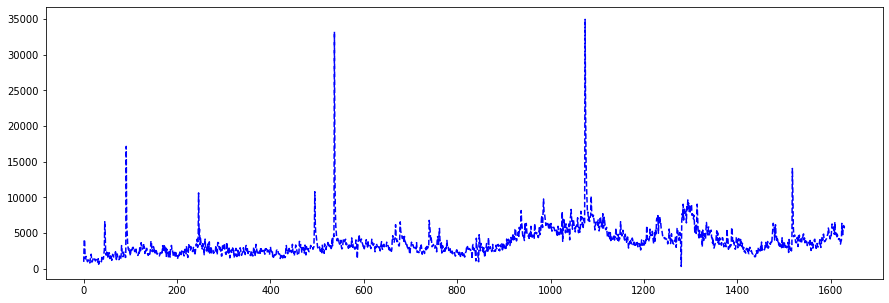

In [24]:
plt.figure(figsize=(15,5))
plt.plot(range(len(data_day)),data_day['Quantidade'], 'b--')
#plt.xlim(4000,4300)
plt.show()

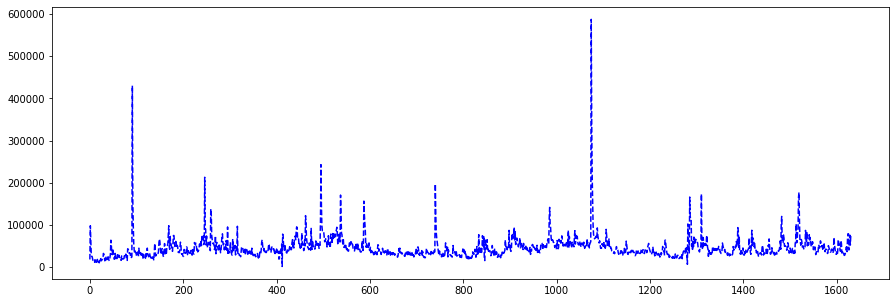

In [25]:
plt.figure(figsize=(15,5))
plt.plot(range(len(data_day)),data_day_all['Quantidade'], 'b--')
#plt.xlim(4000,4300)
plt.show()

In [26]:
time_steps = 20
test_size = 120

train_size = int(len(data_day_features_all)-(test_size))

#train_size = int(len(data_day_features)-(test_size))

train, test = data_day_features_all.iloc[0:train_size], data_day_features_all.iloc[(train_size-time_steps):len(data_day_features_all)]

#train, test = data_day_features.iloc[0:train_size], data_day_features.iloc[(train_size-time_steps):len(data_day_features)]

print(len(train), len(test))

1511 140


In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#price
        v = np.append(v,X.iloc[i + time_steps,2])#d_semana
        v = np.append(v,X.iloc[i + time_steps,3])#d_mes
        v = np.append(v,X.iloc[i + time_steps,4])#d_ano
        Xs.append([v])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['Quantidade'], time_steps)
X_test, y_test = create_dataset(test, test['Quantidade'], time_steps)



In [28]:
print(len(y_train),len(y_test))

1491 120


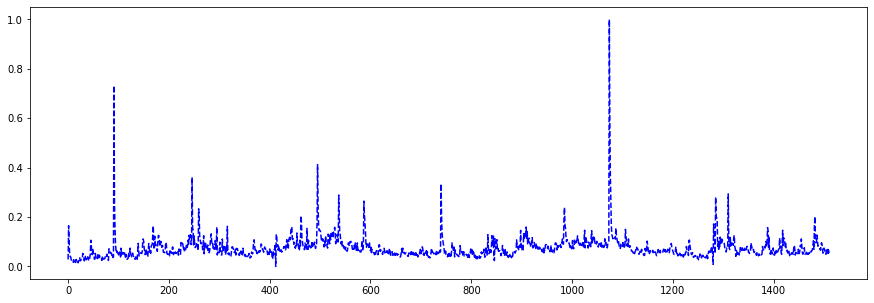

In [29]:
plt.figure(figsize=(15,5))
plt.plot(range(len(train)),train['Quantidade'], 'b--')
#plt.xlim(4000,4300)
plt.show()

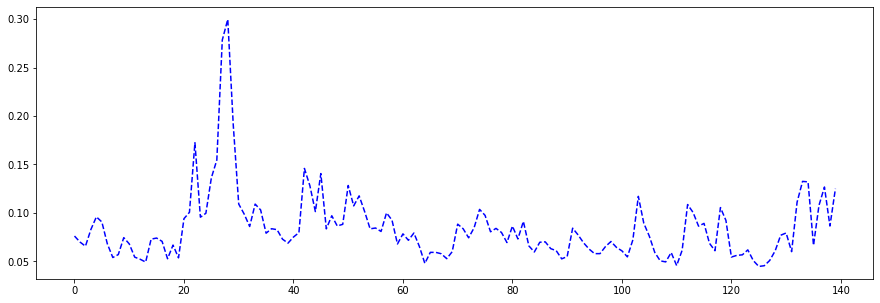

In [30]:
plt.figure(figsize=(15,5))
plt.plot(range(len(test)),test['Quantidade'], 'b--')
#plt.xlim(4000,4300)
plt.show()

In [31]:
nsamples, nx, ny = X_train.shape
d2_xtrain_dataset = X_train.reshape((nsamples,nx*ny))
d2_xtrain_dataset


array([[0.02828314, 0.16456091, 0.10922192, ..., 0.        , 0.03333333,
        0.08539945],
       [0.16456091, 0.10922192, 0.0460063 , ..., 0.25      , 0.06666667,
        0.08815427],
       [0.10922192, 0.0460063 , 0.04037885, ..., 0.5       , 0.1       ,
        0.09090909],
       ...,
       [0.08172555, 0.08399138, 0.08140398, ..., 1.        , 0.36666667,
        0.11294766],
       [0.08399138, 0.08140398, 0.07607044, ..., 0.5       , 0.53333333,
        0.12672176],
       [0.08140398, 0.07607044, 0.06991375, ..., 0.75      , 0.56666667,
        0.12947658]])

In [32]:
parameters = [{
'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
'C': [1,2,3,300,500],
'max_iter': [1000,100000]}]

In [33]:
#clf = GridSearchCV(
#        SVR(), parameters, scoring='r2'
#    )
#x_fit = clf.fit(d2_xtrain_dataset, y_train)

In [34]:
d2_xtrain_dataset

array([[0.02828314, 0.16456091, 0.10922192, ..., 0.        , 0.03333333,
        0.08539945],
       [0.16456091, 0.10922192, 0.0460063 , ..., 0.25      , 0.06666667,
        0.08815427],
       [0.10922192, 0.0460063 , 0.04037885, ..., 0.5       , 0.1       ,
        0.09090909],
       ...,
       [0.08172555, 0.08399138, 0.08140398, ..., 1.        , 0.36666667,
        0.11294766],
       [0.08399138, 0.08140398, 0.07607044, ..., 0.5       , 0.53333333,
        0.12672176],
       [0.08140398, 0.07607044, 0.06991375, ..., 0.75      , 0.56666667,
        0.12947658]])

In [35]:
def getModel():
    model = tf.keras.Sequential()
    #leaky_relu = LeakyReLU(alpha=0.01)
    
    # MLP    
    #model.add(tf.keras.layers.Dense(300, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(tf.keras.layers.Dense(3000, activation="selu", input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(tf.keras.layers.Dense(1000, activation="selu")) 
    #model.add(tf.keras.layers.Dense(900, activation="selu",input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(tf.keras.layers.Dense(300, activation="selu"))
    #model.add(tf.keras.layers.Dense(100, activation="relu"))
    #model.add(tf.keras.layers.Dense(90, activation="relu"))
    #model.add(tf.keras.layers.Dense(30, activation="relu"))
    #model.add(tf.keras.layers.Dense(10, activation="relu"))
    
    # Vanilla LSTM
    #model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        
    # Stacked LSTM
    model.add(tf.keras.layers.LSTM(3000, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.LSTM(1000, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(300, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(30, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(10, activation='relu'))
    
    # Bidirectional LSTM
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Dense(units=1))
    
    return model

In [36]:
model = getModel()

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)

In [37]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True))

history = model.fit(
    X_train, y_train,
    epochs=10, #1000
    batch_size=32, # 30
    validation_split=0.4,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/10
28/28 [==============================] - 28s 752ms/step - loss: 0.0048 - val_loss: 0.0046 - lr: 0.0010
Epoch 2/10
28/28 [==============================] - 20s 700ms/step - loss: 0.0023 - val_loss: 0.0031 - lr: 0.0010
Epoch 3/10
28/28 [==============================] - 20s 699ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 4/10
28/28 [==============================] - 19s 693ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 5/10
28/28 [==============================] - 19s 695ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 6/10
28/28 [==============================] - 19s 689ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/10
28/28 [==============================] - 19s 689ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 8/10
28/28 [==============================] - 19s 689ms/step - loss: 0.0019 - val_loss: 0.0030 - lr: 0.0010
Epoch 9/10
28/28 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00009: 

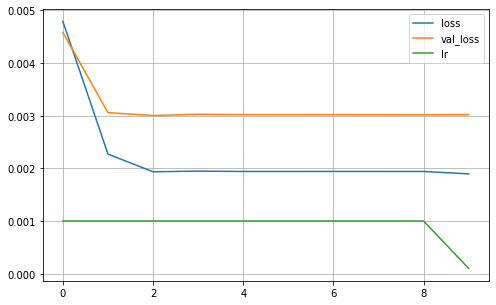

In [38]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Avaliando o modelo

In [39]:
# PREVENDO test_size DIAS

preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    
    y_pred = model.predict(np.array([base_teste[i]]))[0][0]

    preds.append(y_pred)

    for k in range(len(preds)):
        
        if k < time_steps:
            if(i<len(base_teste)-1):
                base_teste[i+1][0][(time_steps-1)-k] = preds[(len(preds)-1)-k]

# preds

In [40]:
base_teste[0].shape

(1, 24)

In [41]:
# APLICANDO O INVERSE SCALING NOS DADOS

dados_pred = {'Quantidade': preds,'d_semana': [0] * test_size,'d_mes': [0] * test_size,'d_ano': [0] * test_size}

data_day = data_day.append(pd.DataFrame(data=dados_pred))

if(transformar_features):
    data_day[feature_names] = scaler.inverse_transform(data_day[feature_names])
# feature_names = ['PU','Quantidade', 'Valor','d_semana','d_mes','d_ano']
df_dados_real_predito = data_day.head(test_size*2)


dados_real = df_dados_real_predito [0:test_size]['Quantidade'].to_numpy()

dados_predito = df_dados_real_predito [test_size:test_size*2]['Quantidade'].to_numpy()


# dados_predito

In [42]:
df_real_predito = pd.DataFrame({'real':dados_real,'predito':dados_predito})

df_real_predito

,real,predito
0,5.515101e+08,1.766178e+09
1,2.396308e+09,1.464815e+09
2,2.228263e+09,1.485779e+09
3,8.575041e+08,2.129256e+09
4,7.928209e+08,1.689874e+09
...,...,...
115,1.212674e+09,1.743188e+09
116,1.083541e+09,1.478145e+09
117,1.217246e+09,1.540703e+09
118,1.342233e+09,1.083090e+09


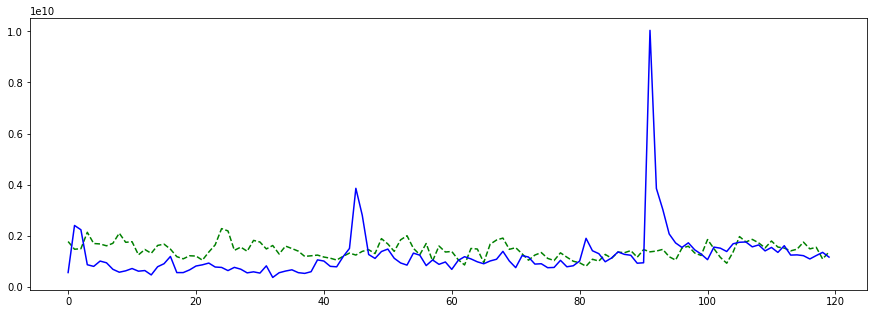

In [43]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,200)
# plt.ylim(40,200)
plt.show()

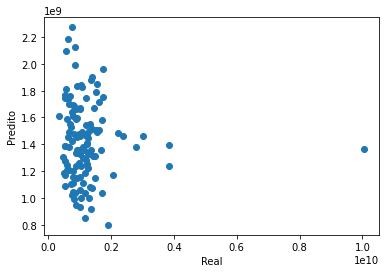

rmse= 1075000810.92633
mae= 624178255.5227702
r2= -0.17259812904237037


In [44]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))